In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mplsoccer import Pitch, FontManager
import requests
import json
import time

from bs4 import BeautifulSoup
from urllib.request import urlopen
from PIL import Image

import ScraperFC as sfc
sofascore = sfc.Sofascore()
urlfont = "https://github.com/google/fonts/blob/main/ofl/belgrano/Belgrano-Regular.ttf"
fuente1 = FontManager(f"{urlfont}?raw=true")

# URL del partido FotMob

In [2]:
urlFotMob = "https://www.fotmob.com/es/matches/independiente-vs-rosario-central/3d0uo7#4393605"

In [3]:
# Obtengo el id de la url de urlFotMob, ubicado luego del #
idFotMob = urlFotMob.split("#")[1]

In [4]:
# Agrego el id en https://www.fotmob.com/api/matchDetails?matchId={idFotMob}
urlFotMob_stats = f"https://www.fotmob.com/api/matchDetails?matchId={idFotMob}"

# URL del partido Sofascore

In [5]:
urlSofascore = "https://www.sofascore.com/rosario-central-independiente/jobsrob#id:11938079"

In [6]:
# URL Sofascore: debemos parsear el string REMOVIENDO el "id:" del string.
# Ejemplo: "https://www.sofascore.com/independiente-rivadavia-rosario-central/robsRLo#id:11938062" --> "https://www.sofascore.com/independiente-rivadavia-rosario-central/robsRLo#11938062"
# Funcion para remover ese "id:" del string.
def remove_id_from_url(url):
    return url.replace('#id:', '#')

# Ahora definimos urlSofascore y urlSofascoreParsed
urlSofascoreParsed = remove_id_from_url(urlSofascore)

### Aqui arranca el análisis con Sofascore

In [7]:
time.sleep(3)
match_stats = sofascore.get_general_match_stats(urlSofascoreParsed)

In [8]:
time.sleep(5)
partido = sofascore.get_match_data(urlSofascoreParsed)
partido

{'tournament': {'name': 'Copa de la Liga',
  'slug': 'copa-de-la-liga',
  'category': {'name': 'Argentina',
   'slug': 'argentina',
   'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
   'id': 48,
   'country': {'alpha2': 'AR', 'name': 'Argentina'},
   'flag': 'argentina',
   'alpha2': 'AR'},
  'uniqueTournament': {'name': 'Copa de la Liga Profesional',
   'slug': 'copa-de-la-liga-profesional',
   'primaryColorHex': '#0cbad8',
   'secondaryColorHex': '#daa813',
   'category': {'name': 'Argentina',
    'slug': 'argentina',
    'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
    'id': 48,
    'country': {'alpha2': 'AR', 'name': 'Argentina'},
    'flag': 'argentina',
    'alpha2': 'AR'},
   'userCount': 36496,
   'id': 13475,
   'country': {},
   'hasEventPlayerStatistics': True,
   'crowdsourcingEnabled': False,
   'hasPerformanceGraphFeature': False,
   'displayInverseHomeAwayTeams': False},
  'priority': 386,
  'competitionType': 1,
  'id': 72142},
 'season': {'n

In [9]:
time.sleep(7)
match_momentum = sofascore.match_momentum(match_url=urlSofascoreParsed)

match_momentum_local = match_momentum[match_momentum['value'] > 0]
match_momentum_visitor = match_momentum[match_momentum['value'] < 0]

In [10]:
idteam1 = partido['homeTeam']['id']
idteam2 = partido['awayTeam']['id']

In [11]:
homecolor = partido['homeTeam']['teamColors']['text']
awaycolor = partido['awayTeam']['teamColors']['text']

In [12]:
time.sleep(5)
escudo1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idteam1}/image'))

time.sleep(8)
escudo2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idteam2}/image'))

In [13]:
goles1 = partido['homeScore']['current']
goles2 = partido['awayScore']['current']

In [14]:
# agregamos un time.sleep para que no se sature la API de sofascore.
time.sleep(5)
#nombre1 = partido['homeTeam']['name']
#nombre2 = partido['awayTeam']['name']
nombre1, nombre2 = sofascore.get_team_names(urlSofascoreParsed)

In [15]:
fecha_partido = partido['roundInfo']['round']
nombre_competencia = partido['tournament']['uniqueTournament']['name']

In [16]:
# agregamos otro time.sleep para que no se sature la API de sofascore.
time.sleep(5)
df_local = sofascore.get_players_match_stats(urlSofascoreParsed)[0]

# agregamos otro time.sleep para que no se sature la API de sofascore.
time.sleep(6)
df_visit = sofascore.get_players_match_stats(urlSofascoreParsed)[1]

# Rellena los valores NaN con ceros en ambos DataFrames
df_local = df_local.fillna(0)
df_visit = df_visit.fillna(0)

In [17]:
def translate_column_name(column_name):
    translations = {
        'name': 'Nombre',
        'slug': 'Apodo',
        'shortName': 'Nombre Corto',
        'position': 'Posición',
        'jerseyNumber': 'Número de Camiseta',
        'userCount': 'Contador de Usuarios',
        'id': 'ID',
        'country': 'País',
        'marketValueCurrency': 'Moneda de Valor de Mercado',
        'dateOfBirthTimestamp': 'Fecha de Nacimiento (Timestamp)',
        'firstName': 'Nombre de Pila',
        'lastName': 'Apellido',
        'fieldTranslations': 'Traducciones de Campo',
        'shirtNumber': 'Número de Camiseta',
        'substitute': 'Suplente',
        'totalPass': 'Pases Totales',
        'accuratePass': 'Pases Precisos',
        'totalLongBalls': 'Pases Largos Totales',
        'accurateLongBalls': 'Pases Largos Precisos',
        'duelWon': 'Duelos Ganados',
        'wasFouled': 'Faltas Recibidas',
        'savedShotsFromInsideTheBox': 'Tiros Salvados Dentro del Área',
        'saves': 'Atajadas',
        'minutesPlayed': 'Minutos Jugados',
        'touches': 'Toques',
        'rating': 'Calificación',
        'possessionLostCtrl': 'Pérdidas de Posesión (Control)',
        'ratingVersions': 'Versiones de Calificación',
        'totalCross': 'Centros Totales',
        'AccurateCross': 'Centros Precisos',
        'aerialLost': 'Duelos Aéreos Perdidos',
        'duelLost': 'Duelos Perdidos',
        'dispossessed': 'Despojado',
        'totalContest': 'Duelos Totales',
        'wonContest': 'Duelos Ganados',
        'totalClearance': 'Despejes Totales',
        'totalTackle': 'Tacleadas Totales',
        'fouls': 'Faltas',
        'keyPass': 'Pases Clave',
        'aerialWon': 'Duelos Aéreos Ganados',
        'challengeLost': 'Desafíos Perdidos',
        'outfielderBlock': 'Bloqueos',
        'interceptionWon': 'Intercepciones Ganadas',
        'shotOffTarget': 'Tiros Fuera del Blanco',
        'onTargetScoringAttempt': 'Intentos de Gol al Blanco',
        'blockedScoringAttempt': 'Intentos de Gol Bloqueados',
        'hitWoodwork': 'Golpe al Poste',
        'totalOffside': 'Offsides Totales',
        'goalAssist': 'Asistencias de Gol',
        'bigChanceCreated': 'Oportunidades Creadas',
        'goals': 'Goles',
        'captain': 'Capitán',
        'team': 'Equipo'
    }
    return translations.get(column_name, column_name)  # Devuelve la traducción o el nombre original si no hay traducción disponible


In [18]:
# Jugador destacado local
name_jugador_destacado_local = df_local[df_local['rating'] == df_local['rating'].max()]['name'].values[0]
# Jugador destacado visitante
name_jugador_destacado_visit = df_visit[df_visit['rating'] == df_visit['rating'].max()]['name'].values[0]

In [19]:
# Obtenemos de df_local y df_visit la informacion de los jugadores destacados
jugador_destacado_local = df_local[df_local['name'] == name_jugador_destacado_local]
jugador_destacado_visit = df_visit[df_visit['name'] == name_jugador_destacado_visit]


In [28]:
jugador_destacado_local['id'].reset_index(drop=True, inplace=True)
jugador_destacado_visit['id'].reset_index(drop=True, inplace=True)

In [29]:
# Obtenemos el id de los jugadores destacados
id_jugador_jugador_destacado_local = jugador_destacado_local['id'][0]
id_jugador_destacado_visit = jugador_destacado_visit['id'][0]

In [34]:
# Creamos funcion que sii el jugador destacado NO es arquero, devuelve el mapa de calor.
def get_heatmap(id_jugador, df):
    if df[df['id'] == id_jugador]['position'].values[0][0] != 'G':
        time.sleep(np.random.randint(5, 10))
        player_name = df[df['id'] == id_jugador]['name'].values[0]
        return sofascore.get_player_heatmap(urlSofascoreParsed, player_name)
    else:
        return None

In [35]:
# Obtenemos el mapa de calor del jugador destacado local
heatmap_local = get_heatmap(id_jugador_jugador_destacado_local, df_local)
# Obtenemos el mapa de calor del jugador destacado visitante
heatmap_visit = get_heatmap(id_jugador_destacado_visit, df_visit)

In [36]:
def obtener_estadisticas_por_posicion(posicion, player):
    if posicion == 'G':
        estadisticas = [
            translate_column_name('minutesPlayed') + ': ' + str(player['minutesPlayed'].values[0]),
            translate_column_name('saves') + ': ' + str(player['saves'].values[0]),
            translate_column_name('savedShotsFromInsideTheBox') + ': ' + str(player['savedShotsFromInsideTheBox'].values[0]),
            translate_column_name('accuratePass') + ': ' + str(player['accuratePass'].values[0]) + '/' + str(player['totalPass'].values[0]),
        ]
    elif posicion == 'D':
        estadisticas = [
            translate_column_name('minutesPlayed') + ': ' + str(player['minutesPlayed'].values[0]),
            translate_column_name('accuratePass') + ': ' + str(player['accuratePass'].values[0]) + '/' + str(player['totalPass'].values[0]),
            translate_column_name('accurateLongBalls') + ': ' + str(player['accurateLongBalls'].values[0]) + '/' + str(player['totalLongBalls'].values[0]),
            translate_column_name('AccurateCross') + ': ' + str(player['accurateCross'].values[0]) + '/' + str(player['totalCross'].values[0]),
            translate_column_name('duelWon') + ': ' + str( str(int(player['duelWon'].values[0])) + '/' + str( int(player['duelWon'].values[0]) + int(player['duelLost'].values[0])) ),
            translate_column_name('totalClearance') + ': ' + str(player['totalClearance'].values[0]),
            translate_column_name('totalTackle') + ': ' + str(player['totalTackle'].values[0]),
            translate_column_name('interceptionWon') + ': ' + str(player['interceptionWon'].values[0]),
            translate_column_name('aerialWon') + ': ' + str(player['aerialWon'].values[0]),
            translate_column_name('fouls') + ': ' + str(player['fouls'].values[0]),
        ]
    elif posicion == 'M':
        estadisticas = [
            translate_column_name('minutesPlayed') + ': ' + str(player['minutesPlayed'].values[0]),
            translate_column_name('accuratePass') + ': ' + str(player['accuratePass'].values[0]) + '/' + str(player['totalPass'].values[0]),
            translate_column_name('accurateLongBalls') + ': ' + str(player['accurateLongBalls'].values[0]) + '/' + str(player['totalLongBalls'].values[0]),
            translate_column_name('AccurateCross') + ': ' + str(player['accurateCross'].values[0]) + '/' + str(player['totalCross'].values[0]),
            translate_column_name('wonContest') + ': ' + str( str(player['wonContest'].values[0]) + '/' + str(player['totalContest'].values[0]) ),
            translate_column_name('keyPass') + ': ' + str(player['keyPass'].values[0]),
            translate_column_name('onTargetScoringAttempt') + ': ' + str(player['onTargetScoringAttempt'].values[0]),
            translate_column_name('bigChanceCreated') + ': ' + str(player['bigChanceCreated'].values[0]),
            translate_column_name('goalAssist') + ': ' + str(player['goalAssist'].values[0]),
            translate_column_name('goals') + ': ' + str(player['goals'].values[0]),
        ]
    elif posicion == 'F':
        estadisticas = [
            translate_column_name('minutesPlayed') + ': ' + str(player['minutesPlayed'].values[0]),
            translate_column_name('onTargetScoringAttempt') + ': ' + str(player['onTargetScoringAttempt'].values[0]),
            translate_column_name('bigChanceCreated') + ': ' + str(player['bigChanceCreated'].values[0]),
            translate_column_name('goalAssist') + ': ' + str(player['goalAssist'].values[0]),
            translate_column_name('shotOffTarget') + ': ' + str(player['shotOffTarget'].values[0]),
            translate_column_name('hitWoodwork') + ': ' + str(player['hitWoodwork'].values[0]),
            translate_column_name('goals') + ': ' + str(player['goals'].values[0]),
            # Agrega más estadísticas específicas para delanteros según sea necesario
        ]
    else:
        # Si la posición no es reconocida, se devuelve una lista vacía
        estadisticas = []
    return estadisticas


In [37]:
# Definimos la lista de estadisticas que queremos del partido, extraidas de 365Score.
lista_estadisticas = ['Ball possession', 'Total shots', 'Shots on target', 'Corner kicks', 'Offsides', 'Fouls', 'Yellow cards', 'Red cards', 'Passes', 'Accurate passes', 'Long balls', 'Possession lost']

In [38]:
match_stats_home = match_stats[["name", "home"]]
match_stats_away = match_stats[["name", "away"]]

In [39]:
home_values = {key:value for key, value in zip(match_stats_home["name"], match_stats_home["home"]) if key in lista_estadisticas}
away_values = {key:value for key, value in zip(match_stats_away["name"], match_stats_away["away"]) if key in lista_estadisticas}

In [40]:
def translate_match_statistic(statistic):
    translations = {
        'Ball possession': 'Posesión de balón',
        'Total shots': 'Tiros totales',
        'Shots on target': 'Tiros al arco',
        'Shots off target': 'Tiros fuera del arco',
        'Blocked shots': 'Tiros bloqueados',
        'Corner kicks': 'Saques de esquina',
        'Offsides': 'Fuera de juego',
        'Fouls': 'Faltas',
        'Red cards': 'Tarjetas rojas',
        'Yellow cards': 'Tarjetas amarillas',
        'Free kicks': 'Tiros libres',
        'Throw-ins': 'Saques de banda',
        'Goal kicks': 'Saques de arco',
        'Big chances': 'Oportunidades claras de gol',
        'Hit woodwork': 'Tiros al palo',
        'Shots inside box': 'Tiros dentro del área',
        'Shots outside box': 'Tiros fuera del área',
        'Goalkeeper saves': 'Atajadas del arquero',
        'Passes': 'Pases',
        'Accurate passes': 'Pases precisos',
        'Long balls': 'Pases largos',
        'Crosses': 'Centros',
        'Dribbles': 'Regates',
        'Possession lost': 'Pérdida de posesión',
        'Duels won': 'Duelos ganados',
        'Aerials won': 'Duelos aéreos ganados',
        'Tackles': 'Entradas',
        'Interceptions': 'Intercepciones',
        'Clearances': 'Despejes'
    }
    
    return translations.get(statistic, statistic)


In [41]:
home_values_translated = {translate_match_statistic(key): value for key, value in home_values.items()}
away_values_translated = {translate_match_statistic(key): value for key, value in away_values.items()}

In [42]:
stats = list(home_values_translated.keys())


In [43]:
time.sleep(np.random.randint(5, 10))
payload = {}
headers = {}

response = requests.request("GET", urlFotMob_stats, headers=headers, data=payload)

print(response.text)

{"general":{"matchId":"4393605","matchName":"Independiente-vs-Rosario Central_Wed, Feb 14, 2024, 00:30 UTC","matchRound":"5","teamColors":{"darkMode":{"home":"#EC1C24","away":"#34558a"},"lightMode":{"home":"#EC1C24","away":"#173B6A"},"fontDarkMode":{"home":"rgba(255, 255, 255, 1.0)","away":"rgba(255, 255, 255, 1.0)"},"fontLightMode":{"home":"rgba(255, 255, 255, 1.0)","away":"rgba(255, 255, 255, 1.0)"}},"leagueId":890036,"leagueName":"Copa de la Liga Profesional","leagueRoundName":"Round 5","parentLeagueId":10007,"countryCode":"ARG","parentLeagueName":"Copa de la Liga Profesional","parentLeagueSeason":"2024","parentLeagueTopScorerLink":"https://data.fotmob.com/stats/10007/season/22636/goals.json","parentLeagueTournamentId":22636,"homeTeam":{"name":"Independiente","id":10078},"awayTeam":{"name":"Rosario Central","id":10084},"coverageLevel":"xG","matchTimeUTC":"Wed, Feb 14, 2024, 00:30 UTC","matchTimeUTCDate":"2024-02-14T00:30:00.000Z","started":true,"finished":true},"header":{"teams":[{"

In [44]:
df_fotmob_general = pd.DataFrame(response.json()['general'])
df_fotmob_general.head()

,matchId,matchName,matchRound,teamColors,leagueId,leagueName,leagueRoundName,parentLeagueId,countryCode,parentLeagueName,parentLeagueSeason,parentLeagueTopScorerLink,parentLeagueTournamentId,homeTeam,awayTeam,coverageLevel,matchTimeUTC,matchTimeUTCDate,started,finished
darkMode,4393605,"Independiente-vs-Rosario Central_Wed, Feb 14, ...",5,"{'home': '#EC1C24', 'away': '#34558a'}",890036,Copa de la Liga Profesional,Round 5,10007,ARG,Copa de la Liga Profesional,2024,https://data.fotmob.com/stats/10007/season/226...,22636,NaN,NaN,xG,"Wed, Feb 14, 2024, 00:30 UTC",2024-02-14T00:30:00.000Z,True,True
lightMode,4393605,"Independiente-vs-Rosario Central_Wed, Feb 14, ...",5,"{'home': '#EC1C24', 'away': '#173B6A'}",890036,Copa de la Liga Profesional,Round 5,10007,ARG,Copa de la Liga Profesional,2024,https://data.fotmob.com/stats/10007/season/226...,22636,NaN,NaN,xG,"Wed, Feb 14, 2024, 00:30 UTC",2024-02-14T00:30:00.000Z,True,True
fontDarkMode,4393605,"Independiente-vs-Rosario Central_Wed, Feb 14, ...",5,"{'home': 'rgba(255, 255, 255, 1.0)', 'away': '...",890036,Copa de la Liga Profesional,Round 5,10007,ARG,Copa de la Liga Profesional,2024,https://data.fotmob.com/stats/10007/season/226...,22636,NaN,NaN,xG,"Wed, Feb 14, 2024, 00:30 UTC",2024-02-14T00:30:00.000Z,True,True
fontLightMode,4393605,"Independiente-vs-Rosario Central_Wed, Feb 14, ...",5,"{'home': 'rgba(255, 255, 255, 1.0)', 'away': '...",890036,Copa de la Liga Profesional,Round 5,10007,ARG,Copa de la Liga Profesional,2024,https://data.fotmob.com/stats/10007/season/226...,22636,NaN,NaN,xG,"Wed, Feb 14, 2024, 00:30 UTC",2024-02-14T00:30:00.000Z,True,True
name,4393605,"Independiente-vs-Rosario Central_Wed, Feb 14, ...",5,NaN,890036,Copa de la Liga Profesional,Round 5,10007,ARG,Copa de la Liga Profesional,2024,https://data.fotmob.com/stats/10007/season/226...,22636,Independiente,Rosario Central,xG,"Wed, Feb 14, 2024, 00:30 UTC",2024-02-14T00:30:00.000Z,True,True


In [45]:
df_fotmob = pd.DataFrame(response.json()['content']['shotmap']['shots'])

In [46]:
id_fotmob_hometeam = pd.DataFrame(response.json()['content']["matchFacts"]["poll"]["oddspoll"]).HomeTeamId[0]
id_fotmob_awayteam = pd.DataFrame(response.json()['content']["matchFacts"]["poll"]["oddspoll"]).AwayTeamId[0]

In [47]:
def get_shoot_coords(local = True):
    if local == True:
        if heatmap_local is None:
            return df_fotmob[(df_fotmob['teamId'] == id_fotmob_awayteam) & (df_fotmob['eventType'] == 'AttemptSaved') & (df_fotmob['isBlocked'] == False)].reset_index(drop=True)
        else:
            return None
    else:
        if heatmap_visit is None:
            return df_fotmob[(df_fotmob['teamId'] == id_fotmob_hometeam) & (df_fotmob['eventType'] == 'AttemptSaved') & (df_fotmob['isBlocked'] == False)].reset_index(drop=True)
        else:
            return None

In [48]:
home_shoots = get_shoot_coords(local = True)
visit_shoots = get_shoot_coords(local = False)

In [49]:
def plot_soccer_pitch(ax, shoots_df):
    width = 24
    height = 8

    increment_x = int(width / 3)
    increment_y = int(height / 2)

    shoots_df['x'] = shoots_df['onGoalShot'].apply(lambda d: d['x'])
    shoots_df['y'] = shoots_df['onGoalShot'].apply(lambda d: d['y'])

    # Normalizar las coordenadas de los tiros al arco
    shoots_df['x_normalized'] = shoots_df['x'] * (width / 2)  # Normalizar x al rango [0, width/2]
    shoots_df['y_normalized'] = shoots_df['y'] * (height / 0.55)  # Normalizar y al rango [0, height] sin invertir

    # Dibuja el arco
    ax.plot([0, 0], [0, height], color='black', lw=3)
    ax.plot([width, width], [0, height], color='black', lw=3)
    ax.plot([0, width], [height, height], color='black', lw=3)

    # Dibuja los marcadores de los tiros
    for i, (x, y, player_name) in enumerate(zip(shoots_df['x_normalized'], shoots_df['y_normalized'], shoots_df['lastName'])):
        ax.scatter(x, y, color='blue', s=200, edgecolors='black')  # No ajustar las coordenadas y para corregir el espejado
        ax.text(x + 0.3, y + 0.3, player_name, color='black', fontsize=10)  # No ajustar las coordenadas y para corregir el espejado

    # Añade color verde y marcas de bins incrementales
    for x in range(0, width, increment_x):
        for y in range(0, height, increment_y):
            rect = plt.Rectangle((x, y), increment_x, increment_y, fc=get_rectangle_color(shoots_df, x, x + increment_x, y, y + increment_y), alpha=0.8)
            ax.add_patch(rect)

            # Añade las líneas de rayas en cada bin
            ax.plot([x, x + increment_x], [y, y], color='black', linestyle='--', lw=0.5)  # Horizontal
            ax.plot([x, x], [y, y + increment_y], color='black', linestyle='--', lw=0.5)  # Vertical

            # Calcula el porcentaje de tiros en este cuadrante
            x_min, x_max = x, x + increment_x
            y_min, y_max = y, y + increment_y
            percentage = calculate_percentage(shoots_df, x_min, x_max, y_min, y_max)
            ax.text(x + increment_x / 2, y + increment_y / 2, f"{percentage:.1%}", ha='center', va='center', color='black')

    # Configuración de los ejes y la visualización
    ax.set_xlim(-1, width + 1)
    ax.set_ylim(-1, height + 1)
    ax.set_axis_off()
    # No invertir el eje y

def calculate_percentage(shoots_df, x_min, x_max, y_min, y_max):
    within_range = (shoots_df['x_normalized'] >= x_min) & (shoots_df['x_normalized'] < x_max) & \
                   (shoots_df['y_normalized'] >= y_min) & (shoots_df['y_normalized'] < y_max)
    total_shots = within_range.sum()
    total_shots_percentage = total_shots / len(shoots_df)
    return total_shots_percentage

def get_rectangle_color(shoots_df, x_min, x_max, y_min, y_max):
    percentage = calculate_percentage(shoots_df, x_min, x_max, y_min, y_max)
    return (1 - percentage, 1, 1 - percentage)  # Blanco para 0%, verde claro muy intenso para 100%


In [50]:
# creamos funcion para quitar spines y ticks de los ejes. También vale hacer ax1.axis('off')
def remove_ticks_and_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

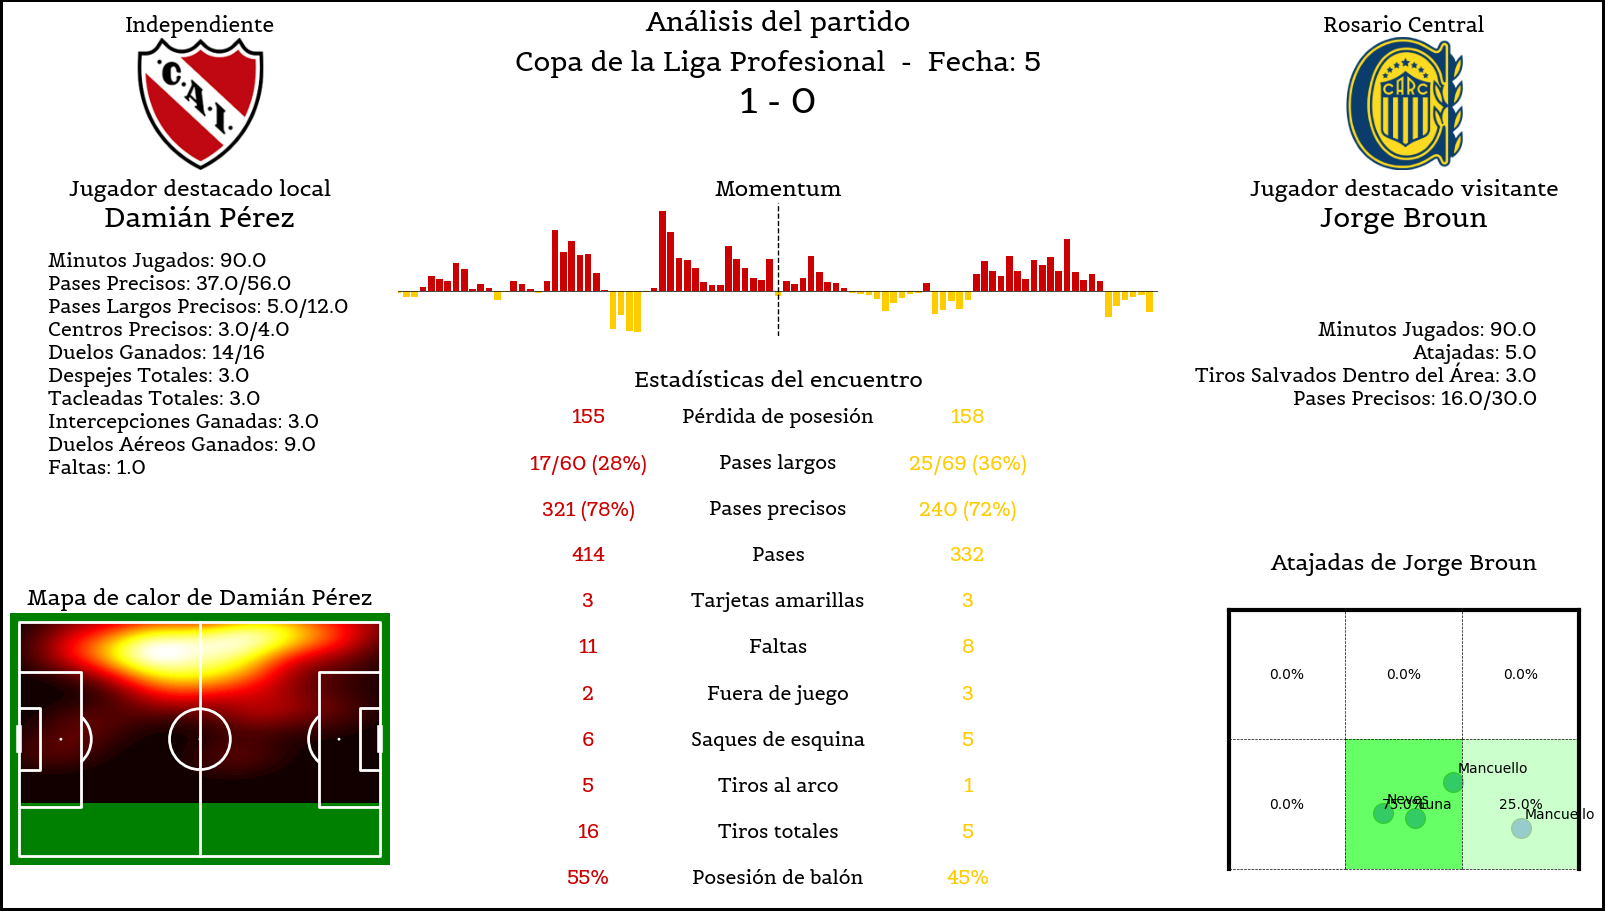

In [55]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=4)
fig.set_facecolor('white')

ax1 = fig.add_subplot(gs[0,0:1])
ax1.set_title(f'{nombre1}', ha='center', va='center', fontproperties=fuente1.prop, size=15)
ax1.imshow(escudo1)
remove_ticks_and_spines(ax1)

ax2 = fig.add_subplot(gs[0,3:4])
ax2.set_title(f'{nombre2}', ha='center', va='center', fontproperties=fuente1.prop, size=15)
ax2.imshow(escudo2)
remove_ticks_and_spines(ax2)

ax3 = fig.add_subplot(gs[0,1:3])
remove_ticks_and_spines(ax3)
ax3.set_title('Análisis del partido', ha='center', va='center', fontproperties=fuente1.prop, size=20)
#ax3.text(0.15, 0.5, f'{nombre1}', ha='left', va='center', fontproperties=fuente1.prop, size=20)
#ax3.text(1.05, 0.5, f'{nombre2}', ha='right', va='center', fontproperties=fuente1.prop, size=20)
#ax3.text(0.5, 0.5, f'-', ha='center', va='center', fontproperties=fuente1.prop, size=20)
ax3.text(0.5,0.5,f'{goles1} - {goles2}',ha='center',va='center', fontproperties=fuente1.prop, size=25)
ax3.text(0.5, 0.8, f'{nombre_competencia}  -  Fecha: {fecha_partido}', ha='center', va='center', fontproperties=fuente1.prop, size=20)

"""ax4 = fig.add_subplot(gs[0,4:5])
ax4.set_title('[0,4:5]')
"""
"""ax5 = fig.add_subplot(gs[0,5:])
ax5.set_title('[0,5:]')"""

ax6 = fig.add_subplot(gs[1:3,:1])
remove_ticks_and_spines(ax6)
ax6.set_title('Jugador destacado local', fontproperties=fuente1.prop, size=16)
ax6.text(0.5, 0.95, f'{name_jugador_destacado_local}', ha='center', va='center', fontproperties=fuente1.prop, size=20)
# Justo debajo del título, agregamos la imagen del jugador destacado local
#ax6.imshow(img_jugador_destacado_local, extent=[0.5, 0.9, 0.5, 2], aspect=0.1)

estadisticas_jugador_destacado_local = obtener_estadisticas_por_posicion(jugador_destacado_local['position'].values[0][0], jugador_destacado_local)
ax6.text(0.1, 0.5, '\n'.join(estadisticas_jugador_destacado_local), ha='left', va='center', fontproperties=fuente1.prop, size=14)

ax7 = fig.add_subplot(gs[2:,1:3])
ax7.set_title('Estadísticas del encuentro', fontproperties=fuente1.prop, size=16)

# Posiciones de los títulos y valores
y_pos = np.arange(len(stats))

# Graficar los títulos de las estadísticas
for i, stat in enumerate(stats):
    ax7.text(0.5, i, stat, color='black', va='center', ha='center', fontproperties=fuente1.prop, size=14)

# Añadir valores del equipo local (home) a la izquierda
for i, val in enumerate(home_values_translated.values()):
    ax7.text(0.25, i, str(val), color=homecolor, va='center', ha='center', fontproperties=fuente1.prop, size=14)

# Añadir valores del equipo visitante (away) a la derecha
for i, val in enumerate(away_values_translated.values()):
    ax7.text(0.75, i, str(val), color=awaycolor, va='center', ha='center', fontproperties=fuente1.prop, size=14)

# Ajustes adicionales
ax7.set_xlim(0, 1)  # Ajustar el límite de x para que los textos estén centrados
ax7.set_ylim(-0.5, len(stats) - 0.5)  # Ajustar el límite de y para centrar las barras
ax7.axis('off')  # Ocultar ejes

# Agregar un subplot para el gráfico "Momentum" encima de las estadísticas del encuentro
ax8 = fig.add_subplot(gs[1:2, 1:3])

# Configurar el título del gráfico "Momentum"
ax8.set_title('Momentum', fontproperties=fuente1.prop, size=16)
ax8.axis('off')  # Ocultar ejes del gráfico
# Graficar el momentum del partido
ax8.bar(match_momentum_local.index, match_momentum_local['value'], color=homecolor, label='Momentum Local')
ax8.bar(match_momentum_visitor.index, match_momentum_visitor['value'], color=awaycolor, label='Momentum Visitante')

# Agregar una línea horizontal en el eje y en 0
ax8.axhline(0, color='black', linewidth=0.5)

# Agregar una línea vertical en el eje x para indicar el cambio al segundo tiempo
ax8.axvline(len(match_momentum) / 2, color='black', linestyle='--', linewidth=1)

# Agregar título de ejes y ajustar los márgenes
ax8.set_xlabel('Minutos', fontproperties=fuente1.prop, size=14)
ax8.set_ylabel('Momentum', fontproperties=fuente1.prop, size=14)
ax8.set_xlim(0, len(match_momentum))  # Ajustar el límite del eje x
ax8.set_ylim(match_momentum['value'].min() * 1.1, match_momentum['value'].max() * 1.1)  # Ajustar el límite del eje y

ax9 = fig.add_subplot(gs[1:3,3:])
remove_ticks_and_spines(ax9)
ax9.set_title('Jugador destacado visitante', fontproperties=fuente1.prop, size=16)
ax9.text(0.5, 0.95, f'{name_jugador_destacado_visit}', ha='center', va='center', fontproperties=fuente1.prop, size=20)
# Justo debajo del título, agregamos la imagen del jugador destacado visitante
#ax9.imshow(img_jugador_destacado_visit)

estadisticas_jugador_destacado_visit = obtener_estadisticas_por_posicion(jugador_destacado_visit['position'].values[0][0], jugador_destacado_visit)
ax9.text(0.85, 0.5, '\n'.join(estadisticas_jugador_destacado_visit), ha='right', va='center', fontproperties=fuente1.prop, size=14)

if heatmap_local is not None:
    ax10 = fig.add_subplot(gs[3:,:1])
    ax10.set_title(f'Mapa de calor de {name_jugador_destacado_local}', fontproperties=fuente1.prop, size=16)
    remove_ticks_and_spines(ax10)
    pitch = Pitch(pitch_type='opta', pitch_color='green', line_color='white')
    pitch.draw(ax=ax10)
    pitch.kdeplot(heatmap_local.x, heatmap_local.y, ax=ax10, cmap='hot', fill=True, zorder=-1, shade_lowest=True, levels=100)
else:
    # Graficamos el arco y los disparos al arco del equipo visitante
    ax10 = fig.add_subplot(gs[3:,:1])
    ax10.set_title(f'Atajadas de {name_jugador_destacado_local}', fontproperties=fuente1.prop, size=16)
    remove_ticks_and_spines(ax10)

    # Llamar a la función plot_soccer_pitch y pasarle el DataFrame con los tiros al arco del equipo visitante
    plot_soccer_pitch(ax10, home_shoots)

if heatmap_visit is not None:
    ax11 = fig.add_subplot(gs[3:,3:])
    ax11.set_title(f'Mapa de calor de {name_jugador_destacado_visit}', fontproperties=fuente1.prop, size=16)
    remove_ticks_and_spines(ax11)
    pitch = Pitch(pitch_type='opta', pitch_color='green', line_color='white')
    pitch.draw(ax=ax11)
    pitch.kdeplot(heatmap_visit.x, heatmap_visit.y, ax=ax11, cmap='hot', fill=True, zorder=-1, shade_lowest=True, levels=100)
else:
    # Graficamos el arco y los disparos al arco del equipo visitante
    ax11 = fig.add_subplot(gs[3:,3:])
    ax11.set_title(f'Atajadas de {name_jugador_destacado_visit}', fontproperties=fuente1.prop, size=16)
    remove_ticks_and_spines(ax11)

    # Llamar a la función plot_soccer_pitch y pasarle el DataFrame con los tiros al arco del equipo visitante
    plot_soccer_pitch(ax11, visit_shoots)


# Ajustes para agregar un marco negro alrededor de la figura entera
fig.patch.set_edgecolor('black')  # Establece el color del borde de la figura
fig.patch.set_linewidth(3)        # Establece el ancho del borde de la figura

plt.show()

fig.savefig(f'dashboard_{nombre1}_vs_{nombre2}.png', bbox_inches='tight', dpi=300) 
